# Boundary conditions for the heat equation: Example 3

We now extend the previously studied heat equation by boundary conditions that vary for different parts of the boundary of our domain. We neglect the inner source and consider the following problem:

\begin{align*}
    \partial_t u -0.1\Delta u &= 0.0 &&\text{ in } [0, 2] \times \Omega &\\
    u(\cdot, 0) &= 0 &&\text{ in } \Omega &\\
    u(x, t) &= 0 , &&\text{ for } x_2=0, & \text{(Dirichlet condition for fixed temperature at the bottom our domain)}\\
    0.1 \nabla u(x, t)\cdot n &= 0 , &&\text{ on } \Gamma_N, & \text{(homogeneous Neumann condition for isolated walls)} \\
    0.1 \nabla u(x, t)\cdot n &= f , &&\text{ on } \Gamma_H, & \text{(Neumann condition for in-flow of heat into our domain).}
\end{align*}

with $\Omega = [0, 1] \times [0, 1]$ and the boundary parts given by:
\begin{align*}
    \Gamma_H &=  [0.2, 0.4] \times \{1\}, \\
    \Gamma_N &=  \partial ([0, 1] \times [0, 1]) \setminus (\{x_2=0\} \cup \Gamma_H).
\end{align*}

In [ ]:
import pathlib
import os
gpu_device = str(int(str(pathlib.Path().resolve())[-2:]) % 8)
os.environ["CUDA_VISIBLE_DEVICES"]= gpu_device

As before, we start by implementing the *Spaces* that appear in the problem:

In [1]:
import torchphysics as tp
X = tp.spaces.R2('x')
U = tp.spaces.R1('u')
T = tp.spaces.R1('t') # <- Add the time variable "t" of dimension 1 (e.g. R1)

/home/nick7/anaconda3/envs/bosch-pde/lib/python3.9/site-packages/pytorch_lightning/metrics/__init__.py:43: LightningDeprecationWarning: `pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package (https://github.com/PyTorchLightning/metrics) since v1.3 and will be removed in v1.5
  rank_zero_deprecation(


We now define the basic parameters and functions that appear in our problem.

In [ ]:
import torch
import pytorch_lightning as pl

# Here all parameters are defined:
t_min, t_max = 0.0, 2.0
prod_speed = 1.0 # speed of heating

size_x, size_y = 1.0, 1.0
x_start, x_end = 0.2, 0.4 # x-size of heat source

kappa = 0.1 # heat diffusion

# Function for heat source
def f(x, t):
    heat_source = 80 * (x[:, :1] - x_start) * (x_end - x[:, :1])
    heat_source *= (1.0 - torch.exp(-prod_speed*t))
    return heat_source

Now we define our domain. The space domain is already completed, here you have to create the time interval and the Cartesian product of both.

In [3]:
omega = tp.domains.Parallelogram(X, [0,0], [size_x,0], [0,size_y])
I_t = tp.domains.Interval(T, 0, 2.0) # <- TODO: add the bounds of the time interval
product_domain = omega * I_t # <- TODO: create the product domain of omega and time domain

Next we need to create some points, this is done by the *Sampler*. Here we need 5 *Samplers*, one inside the domain, 3 for the boundary and one for the initial condition.

In [ ]:
### TODO: To evaluate the PDE condition (in the inner part of the domain) as well as the initial condition, we create similar samplers to before:
inner_sampler = tp.samplers.RandomUniformSampler(product_domain, n_points=25000)
initial_sampler = tp.samplers.RandomUniformSampler(omega*I_t.boundary_left, n_points=5000)

# We now have 3 different boundary conditions that should be satisfied.
# filter-based samplers can be created as follows:

def bottom_filter(x): # for the Dirichlet condition at the bottom of the domain
    return x[..., 1] == 0
bottom_sampler = tp.samplers.RandomUniformSampler(omega.boundary*I_t, 10000, filter_fn=bottom_filter)

### TODO: create a filter-based sampler for the in-flow Neumann condition.
# if you are not sure which points are created or if you want to play with the possibilities, have a look at the cell below.
def inflow_filter(x):
    return (x[..., 1] == 1) & (x[..., 0] > x_start) & (x[..., 0] < x_end)
inflow_sampler = tp.samplers.RandomUniformSampler(omega.boundary*I_t, 5000, filter_fn=inflow_filter)

def isolated_filter(x):
    return ~ (bottom_filter(x) | inflow_filter(x))
### TODO: create a sampler to sample 10000 points on the isolated parts, where you sample random uniformly distributed points
isolated_sampler = tp.samplers.RandomUniformSampler(omega.boundary*I_t, 10000, filter_fn=isolated_filter)

Let's visualize the points that are sampled: you can play around with some samplers and filters on the domain and its boundary and look at the resulting points.

In [ ]:
def just_for_fun_filter(x, t):
    return ...

just_for_fun_sampler = tp.samplers.RandomUniformSampler(omega.boundary, 100, filter_fn=just_for_fun_filter)

tp.utils.scatter(X, just_for_fun_sampler)

The neural network to learn the solution, gets as an input the time and space variable and outputs the solution u. Add the correct spaces.

In [6]:
model = tp.models.FCN(input_space=T*X, output_space=U, hidden=(30,30,30))

Now, we have to transform out mathematical conditions given by our PDE into corresponding training conditions.

First we handle the PDE itself. Here, you have to finish the residual function.

In [7]:
def pde_residual(u, x, t):
    # in the differential operators you have to pass in the correct variables
    # for the derivative computation as the second argument
    # TODO: combine tp.utils.grad(u, t) and tp.utils.laplacian(u, x) in the correct way to implement the PDE residual
    return tp.utils.grad(u, t) - kappa*tp.utils.laplacian(u, x)

pde_cond = tp.conditions.PINNCondition(model, inner_sampler, pde_residual)

We now also need the initial condition ...

In [8]:
### TODO: Implement the residual for the initial condition:
def initial_residual(u):
    return u

initial_cond = tp.conditions.PINNCondition(model, initial_sampler, initial_residual, weight=1.)

... and the boundary conditions:

In [9]:
### TODO: implement the residual for the Dirichlet condition at the bottom of the domain
def bottom_residual(u):
    return u

bottom_cond = tp.conditions.PINNCondition(model, bottom_sampler, bottom_residual)


# Condition for the Neumann in-flow
def inflow_residual(u, x, t):
    normal_vectors = omega.boundary.normal(x)
    normal_derivative = tp.utils.normal_derivative(u, normal_vectors, x)
    ### TODO: return the residual for the in-flow part of the problem
    return kappa * normal_derivative - f(x, t)
### TODO: define the condition for the inflow
inflow_cond = tp.conditions.PINNCondition(model, inflow_sampler, inflow_residual)


### TODO: implement the whole residual for the isolated part of the boundary
def isolated_residual(u, x, t):
    normal_vectors = omega.boundary.normal(x)
    normal_derivative = tp.utils.normal_derivative(u, normal_vectors, x)
    return kappa * normal_derivative

isolated_cond = tp.conditions.PINNCondition(model, isolated_sampler, isolated_residual, weight=10.)
# a weight larger than the default 1.0 puts a larger emphasis on the certain condition in the optimization task

Before the training, we collect all conditions and choose our training procedure:

In [10]:
optim = tp.OptimizerSetting(torch.optim.Adam, lr=1e-3)
### TODO: add the missing conditions
solver = tp.solver.Solver([pde_cond, initial_cond, bottom_cond, inflow_cond, isolated_cond], optimizer_setting=optim)

Start the training:

In [11]:
import pytorch_lightning as pl
trainer = pl.Trainer(devices=1, accelerator="gpu", # use one GPU
                     max_steps=5000, # iteration number
                     benchmark=True, # faster if input batch has constant size
                     logger=False, # for writting into tensorboard
                     enable_checkpointing=False)
trainer.fit(solver)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 2.0 K 
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/nick7/anaconda3/envs/bosch-pde/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/nick7/anaconda3/envs/bosch-pde/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/home/nick7/bosch/torchphysics_fork/torchphysics/src/torchphysics/problem/samplers/sampler_base.py:229: UserWarning: Sampling points with filter did run 10
                              iterations and until now only found 
                              2409 from 5000 points.
                              This may take some time.
  warnings.warn(f"""Sampling points with filter did run 10
/home/nick7/bosch/torchphysics_fork/torchphysics/src/torchphysics/problem/samplers/sampler_base.py:229: UserWarning: Sampling points with filter did run 10
                              iterations and until now only found 
                              2470 from 5000 points.
                              This may take some time.
  warnings.warn(f"""Sampling points with filter did run 10
/home/nick7/bosch/torchphysics_fork/torchphysics/src/torchphysics/problem/samplers/sampler_base.py:229: UserWarning: Sampling points with filter did run 10
                              iterations and until now only foun

Validating: 0it [00:00, ?it/s]

We can plot the solution, for two different time points:

/home/nick7/anaconda3/envs/bosch-pde/lib/python3.9/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/nick7/bosch/torchphysics_fork/torchphysics/src/torchphysics/problem/domains/domain2D/parallelogram.py:134: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2318.)
  bary_coords = torch.stack(torch.meshgrid((x, y))).T.reshape(-1, 2)
/home/nick7/bosch/torchphysics_fork/torchphysics/src/torchphysics/utils/plotting/plot_functions.py:416: UserWarning: C

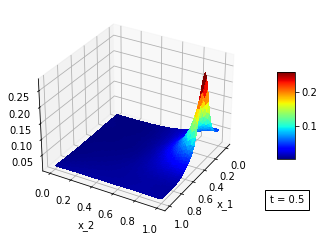

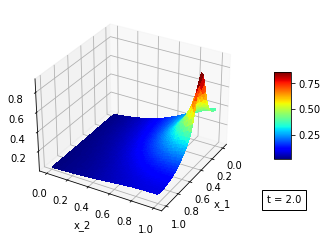

In [ ]:
plot_sampler = tp.samplers.PlotSampler(plot_domain=omega, n_points=2000, data_for_other_variables={"t": 0.5})
fig = tp.utils.plot(model, lambda u : u, plot_sampler)


plot_sampler = tp.samplers.PlotSampler(plot_domain=omega, n_points=2000, data_for_other_variables={"t": 2.0})
fig = tp.utils.plot(model, lambda u : u, plot_sampler)

MovieWriter ffmpeg unavailable; using Pillow instead.


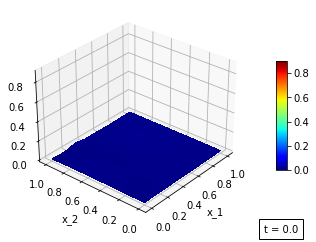

In [ ]:
# We can also animate the solution over time
anim_sampler = tp.samplers.AnimationSampler(omega, I_t, 200, n_points=1000)
fig, anim = tp.utils.animate(model, lambda u: u, anim_sampler, ani_speed=10, angle=[30, 220])
anim.save('heat-eq.gif')
# On Google colab you have at the left side a tab with a folder. There you can find the gif and can watch it.